In [45]:
import sys
sys.path.append('/home/gperri-ext/master_thesis_tryout-2/')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from models.daily_errors import calculate_rmse_errors, calculate_mae_errors, calculate_mape_errors, visualize_errors_with_timestamps, filter_errors_at_midnight
from models.evaluation_func import single_timeseries_evaluation_metrics_func, evaluate_and_plot_timeseries, NMAE_error
from models.visualization import plot_model_loss, plot_error_metrics_barchart, plot_model_rmse_and_loss
from models.windowing_data import multivariate_data, prepare_data
from models.temp_features import make_yearly_dataset, create_cyclic_features, transform_time_features

from tensorflow import keras, config
from keras import layers

physical_devices = config.list_physical_devices('GPU') 
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

%matplotlib inline


ImportError: cannot import name 'errors_on_rows' from 'models.daily_errors' (/home/gperri-ext/master_thesis_tryout-2/models/daily_errors.py)

### Importing data

In [4]:
data_folder = "/home/gperri-ext/master_thesis_tryout-2/data"
file_name = "all_data.csv"

try:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    
except FileNotFoundError:
    print("File not found. Please provide the correct path to the data folder.")

In [5]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

In [6]:
# Separate features inputs
df_PUN = df.iloc[:, :3]
df_GAS = df.iloc[:, :5]
df_total_load = df.iloc[:, :7]
df_PUN7 = df.iloc[:,:2]
df_no_tlf = df[['PUN','PUN_d+1-7','GAS', 'GAS_d+1-7','Total_Load_d+1-7','GiornoSettimana', 'Ora', 'holiday']]

### Preparing I/O

In [74]:
# df.columns
# df_temp = df[['PUN','PUN_d+1-7','GAS','GiornoSettimana', 'Ora', 'holiday']]

In [75]:
# Choose dataset input
# dataset_input = make_yearly_dataset(df_no_tlf, 2018, 2023)
dataset_input = df_no_tlf
print(dataset_input.head(5))

                             PUN  PUN_d+1-7    GAS  GAS_d+1-7   
Time_data                                                       
2018-01-15 00:00:00+00:00  41.56      39.17  21.14      20.54  \
2018-01-15 01:00:00+00:00  35.15      36.40  21.14      20.54   
2018-01-15 02:00:00+00:00  32.55      35.90  21.14      20.54   
2018-01-15 03:00:00+00:00  32.78      34.00  21.14      20.54   
2018-01-15 04:00:00+00:00  32.55      35.35  21.14      20.54   

                           Total_Load_d+1-7  GiornoSettimana  Ora  holiday  
Time_data                                                                   
2018-01-15 00:00:00+00:00          27513.29                0    1        0  
2018-01-15 01:00:00+00:00          25886.82                0    2        0  
2018-01-15 02:00:00+00:00          25241.74                0    3        0  
2018-01-15 03:00:00+00:00          25072.75                0    4        0  
2018-01-15 04:00:00+00:00          25184.83                0    5        0  


In [52]:
# RIMUOVI 2022

# dataset_input = dataset_input[~dataset_input.index.year.isin([2022])]

In [76]:
target_size = 24
past_history = 24

step = 1


In [77]:
univariate = False

X, y = prepare_data(dataset_input, univariate=univariate)

In [78]:
# Divisione in training, validation e test set
train_index = int(len(dataset_input) * 0.8)
cv_index = train_index + int(len(dataset_input) * 0.05)
test_index = cv_index + int(len(dataset_input) * 0.15)

In [79]:
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X)
y_sc.fit(y)

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()


In [80]:
X_train, y_train = multivariate_data(X_norm, y_norm,
                                     0, train_index, past_history, 
                                     target_size, step=step, single_step=False)

X_val, y_val = multivariate_data(X_norm, y_norm,
                                 train_index, cv_index, past_history, 
                                 target_size, step=step, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                   cv_index, test_index, past_history, 
                                   target_size, step=step, single_step=False)


In [81]:
# y_test = y_test.reshape(-1, 1) # questo se single step = True
y_test_inv = y_sc.inverse_transform(y_test)

In [82]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

### Xgb train with "rndm" parameters

In [83]:
param = {'eta': 0.5, 'max_depth': 50, 
         'subsample': 0.9, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

param_found = {'alpha': 0.6226863736818766,
        'colsample_bytree': 0.9962076141060994,
        'eta': 0.03052686097168219,
        'gamma': 0.005535703009561729,
        'lambda': 0.3111343213304369,
        'max_depth': 1,
        'min_child_weight': 0.1848493439286908,
        'subsample': 0.6789984667163211}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)

eval_list = [(dtrain, 'train'), (dval, 'eval')]

'''lambda [default=1, alias: reg_lambda]
L2 regularization term on weights (analogous to Ridge regression). 
This is used to handle the regularization part of XGBoost. 


alpha [default=0, alias: reg_alpha]
L1 regularization term on weights (analogous to Lasso regression).
'''

'lambda [default=1, alias: reg_lambda]\nL2 regularization term on weights (analogous to Ridge regression). \nThis is used to handle the regularization part of XGBoost. \n\n\nalpha [default=0, alias: reg_alpha]\nL1 regularization term on weights (analogous to Lasso regression).\n'

In [84]:
# for hyperparameters tuning see  Bayesian Optimization with HYPEROPT.
xgb_model = xgb.train(param, dtrain, 200, eval_list, early_stopping_rounds=10)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[12:59:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:59:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:0.20020	eval-rmse:0.13095
[1]	train-rmse:0.10160	eval-rmse:0.08767
[2]	train-rmse:0.05339	eval-rmse:0.07033
[3]	train-rmse:0.03105	eval-rmse:0.06388
[4]	train-rmse:0.02191	eval-rmse:0.06126
[5]	train-rmse:0.01873	eval-rmse:0.06046
[6]	train-rmse:0.01770	eval-rmse:0.05987
[7]	train-rmse:0.01730	eval-rmse:0.05939
[8]	train-rmse:0.01715	eval-rmse:0.05917
[9]	train-rmse:0.01704	eval-rmse:0.05900
[10]	train-rmse:0.01699	eval-rmse:0.05894
[11]	train-rmse:0.01698	eval-rmse:0.05892
[12]	train-rmse:0.01695	eval-rmse:0.05891
[13]	train-rmse:0.01694	eval-rmse:0.05887
[14]	train-rmse:0.01694	eval-rmse:0.05887
[15]	train-rmse:0.01690	eval-rmse:0.05886
[16]	train-rmse:0.01690	eval-rmse:0.05886
[17]	train-rmse:0.01690	eval-rmse:0.05886
[18]	train-rmse:0.01686	eval-rmse:0.05884
[19]	trai

In [ ]:
forecast = xgb_model.predict(dtest)
# xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = y_sc.inverse_transform(forecast)

In [ ]:
print(y_test_inv.shape)
print(forecast.shape)
print(xgb_forecast_inv.shape)
print(f'DMatrix rows: {dtest.num_row()}, columns: {dtest.num_col()}')

(6176, 24)
(6176, 24)
(6176, 24)
DMatrix rows: 6176, columns: 192


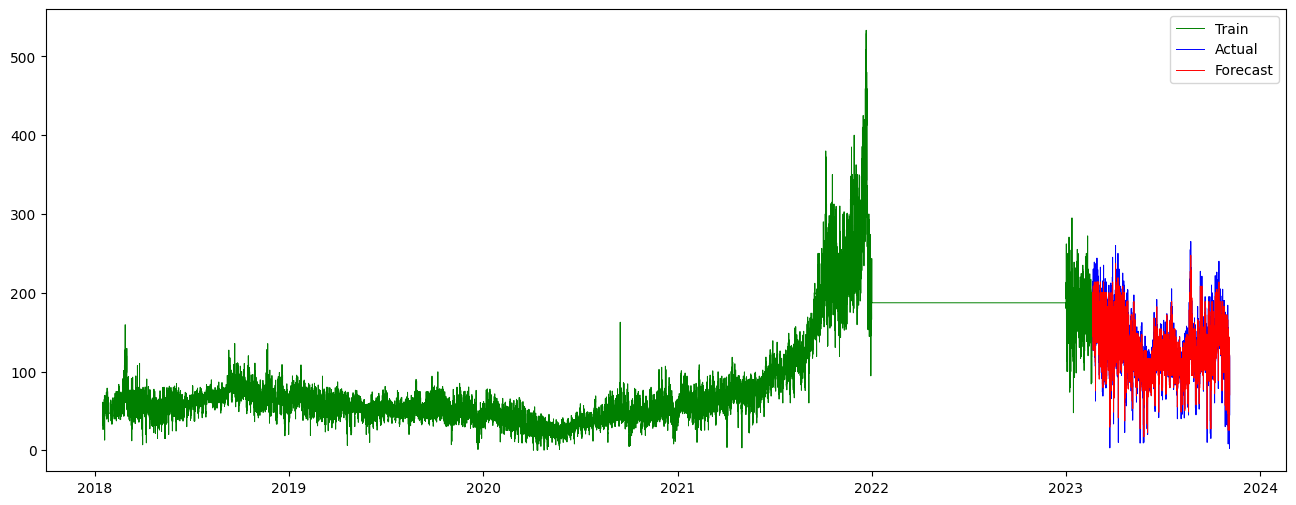

In [ ]:
dates_train = dataset_input.index[:train_index]
dates_cv = dataset_input.index[train_index:cv_index]
dates_test = dataset_input.index[cv_index:]

# A visual representation
plt.figure(figsize=(16, 6))
plt.plot(dates_train, y_sc.inverse_transform(y_train)[:,0], linewidth=0.7, color='g', label='Train')
plt.plot(dates_cv, y_sc.inverse_transform(y_val)[:,0], linewidth=0.7, color='g')
plt.plot(dates_test[:len(y_test)], y_test_inv[:,0], linewidth=0.7, label='Actual', color='b')
plt.plot(dates_test[:len(y_test)], xgb_forecast_inv[:,0], linewidth=0.7, color='r', label='Forecast')
plt.legend()
plt.show()

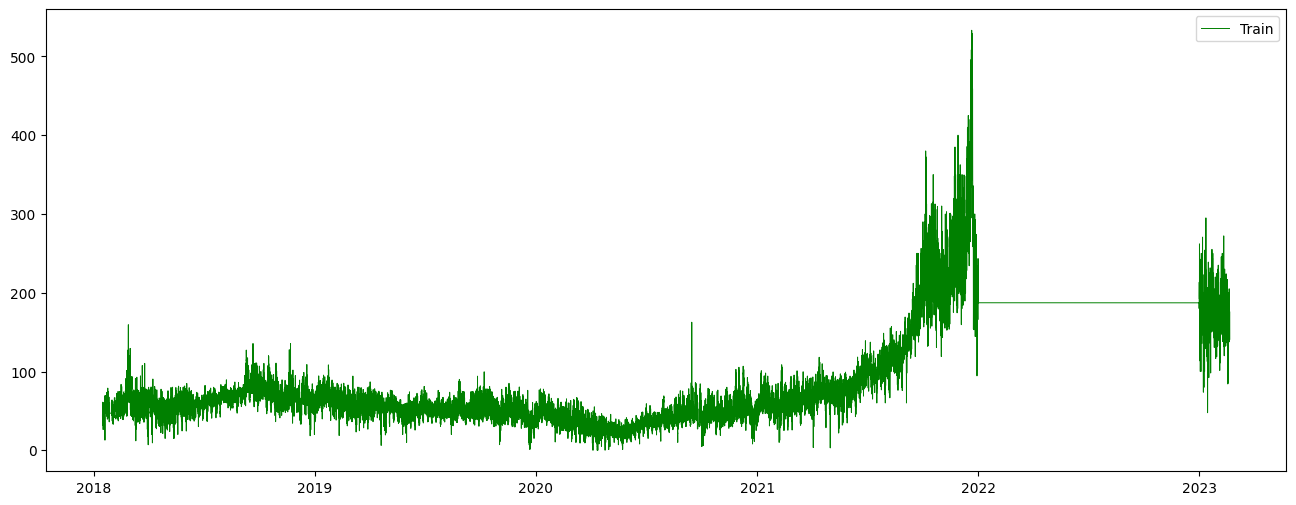

In [ ]:
# A visual representation
plt.figure(figsize=(16, 6))
plt.plot(dates_train, y_sc.inverse_transform(y_train)[:,0], linewidth=0.7, color='g', label='Train')
plt.plot(dates_cv, y_sc.inverse_transform(y_val)[:,0], linewidth=0.7, color='g')
plt.legend()
plt.show()

In [ ]:
xgboost_table = evaluate_and_plot_timeseries(y_test_inv, xgb_forecast_inv, show_plot=False)


Min NMAE: 0.074 for Column: 0.0
Min RMSE: 12.778 for Column: 0.0
Min MAPE: 9.476 for Column: 0.0
Mean NMAE: 0.11166666666666668
Mean RMSE: 19.040166666666668
Mean MAPE: 16.742125


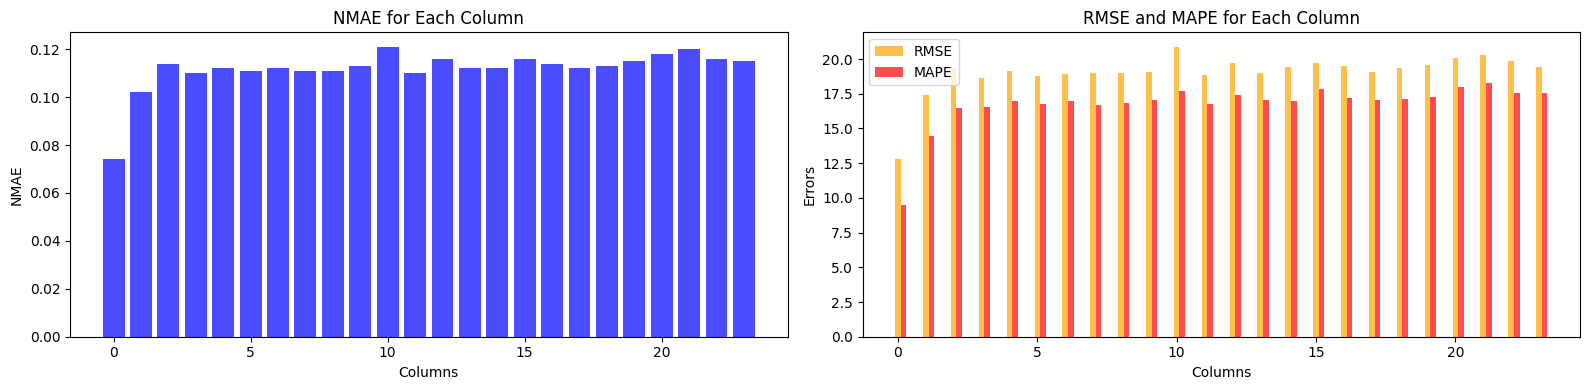

In [ ]:
plot_error_metrics_barchart(xgboost_table)

In [ ]:
def errors_on_rows(y_test_inv, forecast, dataset_input):
    errors = calculate_rmse_errors(y_test_inv, forecast)
    # Ottieni il timestamp per le righe di test
    test_timestamps = dataset_input.iloc[-y_test_inv.shape[0]:].index

    # Converti l'indice in oggetti datetime
    test_timestamps = pd.to_datetime(test_timestamps)
    midnight_errors, midnight_timestamps = filter_errors_at_midnight(errors, test_timestamps)

    mean_midnight_error = np.mean(midnight_errors)

    visualize_errors_with_timestamps(midnight_errors, midnight_timestamps, mean_midnight_error)


    print("RMSE total:", mean_midnight_error)

Errore relativo a 257 giorni, a partire da mezzanotte


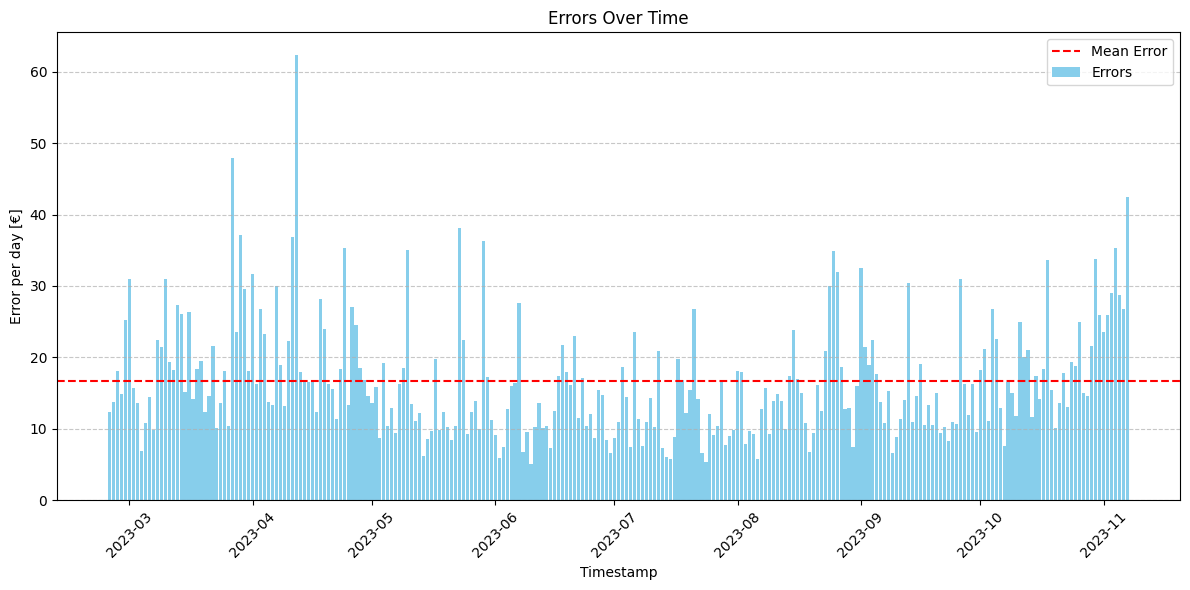

RMSE total: 16.672278025401194


In [ ]:
# da sistemare, vorrei aggiungere che scegli anche la metrica degli errori
errors_on_rows(y_test_inv, xgb_forecast_inv, dataset_input)

### Hyperparameter search: HYPEROPT

In [50]:
from hyperopt import hp, fmin, tpe, Trials
from sklearn.metrics import mean_squared_error

''' TPE is a default algorithm for the Hyperopt. It uses Bayesian approach for optimization. 
    At every step it is trying to build probabilistic model of the function and choose the most promising parameters for the next step.
    '''

space = {
    'eta': hp.uniform('eta', 0.01, 0.5),
    'max_depth': hp.choice('max_depth', range(1, 15)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'alpha': hp.uniform('alpha', 0, 1),
    'lambda': hp.uniform('lambda', 0, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 1)
}

In [39]:
# Funzione di obiettivo da minimizzare (ad esempio, RMSE)
def objective(params):
    dtrain = xgb.DMatrix(X_train_xgb, y_train)
    dval = xgb.DMatrix(X_val_xgb, y_val)
    eval_list = [(dtrain, 'train'), (dval, 'eval')]
    xgb_model = xgb.train(params, dtrain, 200, eval_list, early_stopping_rounds=10, verbose_eval=False)
    forecast = xgb_model.predict(dval)
    rmse = mean_squared_error(y_val, forecast, squared=False)
    return rmse

In [40]:
# Ottimizzazione degli iperparametri utilizzando Hyperopt
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

# Stampare i migliori iperparametri trovati
print("Best hyperparameters:")
print(best)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  1%|          | 1/100 [00:21<35:43, 21.65s/trial, best loss: 0.012345850000461699]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|▏         | 2/100 [00:56<48:16, 29.55s/trial, best loss: 0.011370866879595534]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  3%|▎         | 3/100 [07:10<5:01:35, 186.55s/trial, best loss: 0.011370866879595534]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|▍         | 4/100 [07:38<3:18:36, 124.13s/trial, best loss: 0.011370866879595534]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  5%|▌         | 5/100 [11:00<4:01:13, 152.35s/trial, best loss: 0.011370866879595534]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|▌         | 6/100 [11:20<2:48:07, 107.31s/trial, best loss: 0.011370866879595534]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  7%|▋         | 7/100 [15:04<3:45:13, 145.31s/trial, best loss: 0.011370866879595534]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|▊         | 8/100 [15:18<2:38:51, 103.60s/trial, best loss: 0.011370866879595534]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  9%|▉         | 9/100 [17:39<2:54:42, 115.19s/trial, best loss: 0.011370866879595534]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|█         | 10/100 [18:26<2:21:14, 94.16s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 11%|█         | 11/100 [22:36<3:30:35, 141.98s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|█▏        | 12/100 [24:55<3:26:48, 141.00s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 13%|█▎        | 13/100 [29:15<4:16:54, 177.18s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|█▍        | 14/100 [30:31<3:29:47, 146.37s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 15%|█▌        | 15/100 [33:11<3:33:23, 150.63s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|█▌        | 16/100 [37:19<4:11:38, 179.75s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 17%|█▋        | 17/100 [37:59<3:10:48, 137.93s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|█▊        | 18/100 [40:59<3:25:33, 150.41s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 19%|█▉        | 19/100 [44:34<3:49:24, 169.93s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|██        | 20/100 [44:43<2:42:03, 121.55s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 21%|██        | 21/100 [45:00<1:58:54, 90.31s/trial, best loss: 0.010662436001778167] 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|██▏       | 22/100 [45:43<1:38:46, 75.98s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 23%|██▎       | 23/100 [46:03<1:16:05, 59.30s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|██▍       | 24/100 [46:35<1:04:36, 51.00s/trial, best loss: 0.010662436001778167]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 25%|██▌       | 25/100 [47:22<1:02:21, 49.88s/trial, best loss: 0.01065930332377385] 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|██▌       | 26/100 [48:29<1:07:51, 55.03s/trial, best loss: 0.01065930332377385]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 27%|██▋       | 27/100 [49:09<1:01:24, 50.47s/trial, best loss: 0.01065930332377385]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|██▊       | 28/100 [51:32<1:34:01, 78.35s/trial, best loss: 0.01065930332377385]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 29%|██▉       | 29/100 [53:51<1:54:06, 96.43s/trial, best loss: 0.01065930332377385]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|███       | 30/100 [54:53<1:40:34, 86.21s/trial, best loss: 0.01065930332377385]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 31%|███       | 31/100 [55:43<1:26:25, 75.15s/trial, best loss: 0.01065930332377385]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|███▏      | 32/100 [57:31<1:36:31, 85.17s/trial, best loss: 0.010426267169011488]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 33%|███▎      | 33/100 [1:01:35<2:28:03, 132.59s/trial, best loss: 0.010426267169011488]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|███▍      | 34/100 [1:03:28<2:19:29, 126.81s/trial, best loss: 0.010426267169011488]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 35%|███▌      | 35/100 [1:04:25<1:54:40, 105.85s/trial, best loss: 0.010426267169011488]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|███▌      | 36/100 [1:06:09<1:52:24, 105.39s/trial, best loss: 0.010426267169011488]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 37%|███▋      | 37/100 [1:06:52<1:30:57, 86.62s/trial, best loss: 0.010426267169011488] 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|███▊      | 38/100 [1:06:59<1:04:55, 62.83s/trial, best loss: 0.010426267169011488]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 39%|███▉      | 39/100 [1:13:07<2:36:56, 154.37s/trial, best loss: 0.010426267169011488]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|████      | 40/100 [1:18:31<3:25:12, 205.21s/trial, best loss: 0.010426267169011488]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 41%|████      | 41/100 [1:25:28<4:24:13, 268.71s/trial, best loss: 0.010426267169011488]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|████▏     | 42/100 [1:26:34<3:20:57, 207.89s/trial, best loss: 0.010426267169011488]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 43%|████▎     | 43/100 [1:28:48<2:56:21, 185.64s/trial, best loss: 0.01028264485177551] 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|████▍     | 44/100 [1:29:37<2:15:08, 144.79s/trial, best loss: 0.01028264485177551]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 45%|████▌     | 45/100 [1:30:35<1:48:56, 118.85s/trial, best loss: 0.01028264485177551]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|████▌     | 46/100 [1:36:27<2:49:43, 188.58s/trial, best loss: 0.01028264485177551]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 47%|████▋     | 47/100 [1:38:53<2:35:28, 176.00s/trial, best loss: 0.01028264485177551]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|████▊     | 48/100 [1:39:10<1:50:59, 128.07s/trial, best loss: 0.01028264485177551]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 49%|████▉     | 49/100 [1:41:41<1:54:43, 134.96s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|█████     | 50/100 [1:44:17<1:57:51, 141.44s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 51%|█████     | 51/100 [1:46:44<1:56:44, 142.95s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|█████▏    | 52/100 [1:47:08<1:25:59, 107.48s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 53%|█████▎    | 53/100 [1:47:58<1:10:34, 90.09s/trial, best loss: 0.009426557741046764] 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|█████▍    | 54/100 [1:51:40<1:39:23, 129.64s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 55%|█████▌    | 55/100 [1:54:57<1:52:26, 149.93s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|█████▌    | 56/100 [1:58:41<2:06:06, 171.97s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 57%|█████▋    | 57/100 [2:00:14<1:46:23, 148.45s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|█████▊    | 58/100 [2:06:16<2:28:47, 212.56s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 59%|█████▉    | 59/100 [2:08:53<2:13:49, 195.84s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|██████    | 60/100 [2:09:37<1:40:05, 150.15s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 61%|██████    | 61/100 [2:10:07<1:14:19, 114.34s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|██████▏   | 62/100 [2:11:16<1:03:43, 100.61s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 63%|██████▎   | 63/100 [2:11:28<45:34, 73.90s/trial, best loss: 0.009426557741046764]   

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|██████▍   | 64/100 [2:18:00<1:41:42, 169.52s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 65%|██████▌   | 65/100 [2:19:12<1:21:48, 140.25s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|██████▌   | 66/100 [2:21:44<1:21:28, 143.77s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 67%|██████▋   | 67/100 [2:23:06<1:08:55, 125.33s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|██████▊   | 68/100 [2:25:14<1:07:11, 125.99s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 69%|██████▉   | 69/100 [2:25:49<50:56, 98.61s/trial, best loss: 0.009426557741046764]   

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|███████   | 70/100 [2:26:27<40:11, 80.40s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 71%|███████   | 71/100 [2:27:56<40:09, 83.10s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|███████▏  | 72/100 [2:30:22<47:36, 102.00s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 73%|███████▎  | 73/100 [2:34:24<1:04:44, 143.87s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|███████▍  | 74/100 [2:35:38<53:19, 123.05s/trial, best loss: 0.009426557741046764]  

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 75%|███████▌  | 75/100 [2:38:52<1:00:08, 144.34s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|███████▌  | 76/100 [2:42:00<1:02:59, 157.47s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 77%|███████▋  | 77/100 [2:50:50<1:43:07, 269.02s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|███████▊  | 78/100 [2:53:37<1:27:26, 238.48s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 79%|███████▉  | 79/100 [2:55:25<1:09:45, 199.29s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|████████  | 80/100 [2:56:15<51:32, 154.62s/trial, best loss: 0.009426557741046764]  

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 81%|████████  | 81/100 [2:58:44<48:26, 152.98s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|████████▏ | 82/100 [3:10:51<1:37:31, 325.09s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 83%|████████▎ | 83/100 [3:11:14<1:06:28, 234.61s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|████████▍ | 84/100 [3:14:12<57:59, 217.49s/trial, best loss: 0.009426557741046764]  

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 85%|████████▌ | 85/100 [3:14:32<39:33, 158.26s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|████████▌ | 86/100 [3:16:08<32:35, 139.67s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 87%|████████▋ | 87/100 [3:16:16<21:41, 100.11s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|████████▊ | 88/100 [3:16:35<15:10, 75.86s/trial, best loss: 0.009426557741046764] 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 89%|████████▉ | 89/100 [3:17:49<13:47, 75.25s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|█████████ | 90/100 [3:18:12<09:54, 59.44s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 91%|█████████ | 91/100 [3:26:46<29:22, 195.82s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|█████████▏| 92/100 [3:27:53<20:57, 157.22s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 93%|█████████▎| 93/100 [3:28:44<14:37, 125.34s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|█████████▍| 94/100 [3:31:47<14:16, 142.68s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 95%|█████████▌| 95/100 [3:32:19<09:07, 109.41s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|█████████▌| 96/100 [3:33:34<06:36, 99.07s/trial, best loss: 0.009426557741046764] 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 97%|█████████▋| 97/100 [3:41:04<10:13, 204.45s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|█████████▊| 98/100 [3:41:14<04:52, 146.09s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 99%|█████████▉| 99/100 [3:43:05<02:15, 135.60s/trial, best loss: 0.009426557741046764]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



100%|██████████| 100/100 [3:43:42<00:00, 134.23s/trial, best loss: 0.009426557741046764]
Best hyperparameters:
{'alpha': 0.6226863736818766, 'colsample_bytree': 0.9962076141060994, 'eta': 0.03052686097168219, 'gamma': 0.005535703009561729, 'lambda': 0.3111343213304369, 'max_depth': 5, 'min_child_weight': 0.1848493439286908, 'subsample': 0.6789984667163211}


In [54]:
min(trials.losses())

0.009426557741046764

In [41]:
best

{'alpha': 0.6226863736818766,
 'colsample_bytree': 0.9962076141060994,
 'eta': 0.03052686097168219,
 'gamma': 0.005535703009561729,
 'lambda': 0.3111343213304369,
 'max_depth': 5,
 'min_child_weight': 0.1848493439286908,
 'subsample': 0.6789984667163211}

In [ ]:
# Per stoppare il kernel, modo brusco, lo uso per fermare il processo di papermill
raise KeyboardInterrupt("Fine lettura")

### XGB regressor

In [40]:
from xgboost import XGBRegressor


xgb_model_sklearn = XGBRegressor(
    learning_rate=0.5,
    max_depth=50,
    subsample=0.9,
    colsample_bytree=0.95,
    alpha=0.1,
    reg_lambda=0.15,
    gamma=0.1,
    objective='reg:squarederror',  # 'reg:linear' è deprecato, 'reg:squarederror' è l'opzione attuale
    n_jobs=-1,
    n_estimators=200,
)

# Addestramento del modello
xgb_model_sklearn.fit(X_train_xgb, y_train, eval_metric='rmse', eval_set=[(X_train_xgb, y_train), (X_val_xgb, y_val)], early_stopping_rounds=10)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.20517	validation_1-rmse:0.16282
[1]	validation_0-rmse:0.10346	validation_1-rmse:0.15252
[2]	validation_0-rmse:0.05323	validation_1-rmse:0.15076
[3]	validation_0-rmse:0.02930	validation_1-rmse:0.15062
[4]	validation_0-rmse:0.01897	validation_1-rmse:0.15119
[5]	validation_0-rmse:0.01519	validation_1-rmse:0.15192
[6]	validation_0-rmse:0.01396	validation_1-rmse:0.15157
[7]	validation_0-rmse:0.01364	validation_1-rmse:0.15181
[8]	validation_0-rmse:0.01355	validation_1-rmse:0.15169
[9]	validation_0-rmse:0.01351	validation_1-rmse:0.15188
[10]	validation_0-rmse:0.01351	validation_1-rmse:0.15196
[11]	validation_0-rmse:0.01348	validation_1-rmse:0.15193
[12]	validation_0-rmse:0.01346	validation_1-rmse:0.15192
[13]	validation_0-rmse:0.01345	validation_1-rmse:0.15178


XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=50, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, ...)

In [41]:
# Predizione sui dati di test
xgb_forecast_sklearn = xgb_model_sklearn.predict(X_test_xgb)


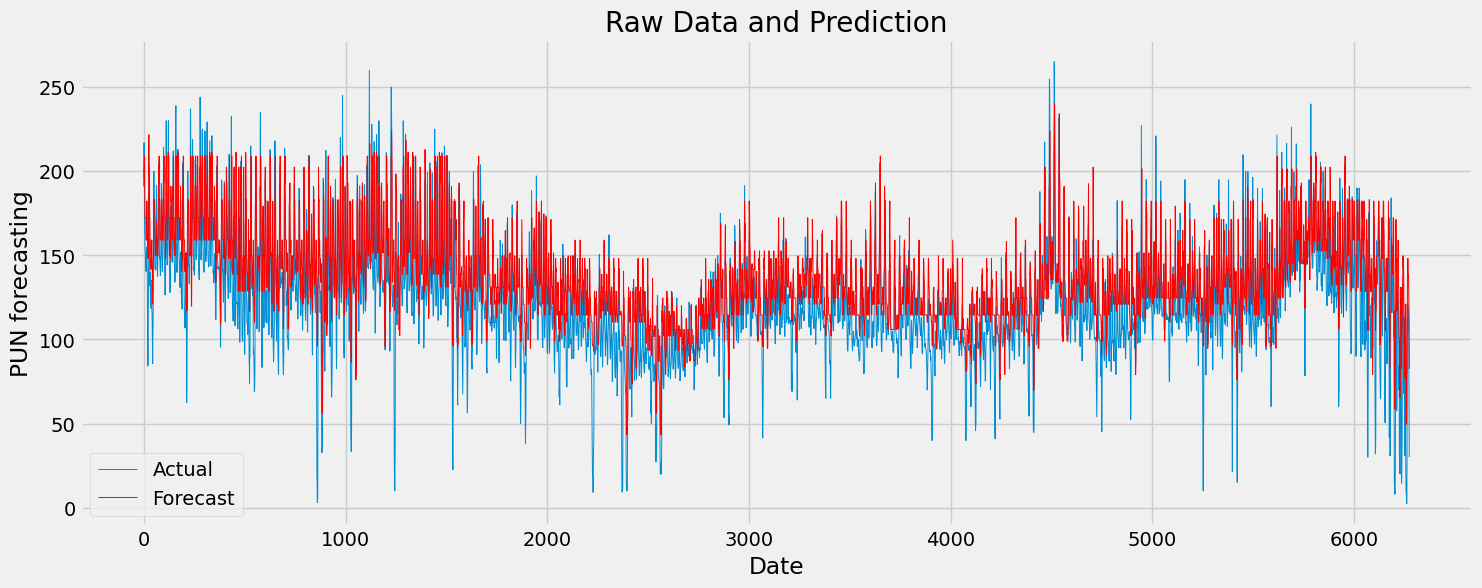

In [51]:
# Denormalizzazione delle previsioni
xgb_forecast_inv_sklearn = y_sc.inverse_transform(xgb_forecast_sklearn)

# Plot dei risultati
plt.figure(figsize=(16, 6))
plt.plot(y_test_inv[:,1], linewidth=0.7, label='Actual')
plt.plot(xgb_forecast_inv_sklearn[:,1], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()




In [52]:
evaluate_and_plot_timeseries(y_test_inv, xgb_forecast_inv_sklearn)


,Column,RMSE,MAPE,NMAE
0,0,19.169,18.927,0.136
1,1,25.383,25.444,0.173
2,2,26.257,25.897,0.171
3,3,27.760,27.665,0.182
4,4,26.677,26.770,0.176
5,5,24.952,25.345,0.163
6,6,27.720,27.431,0.182
7,7,26.872,26.782,0.175
8,8,27.231,27.229,0.180
9,9,27.165,27.042,0.178


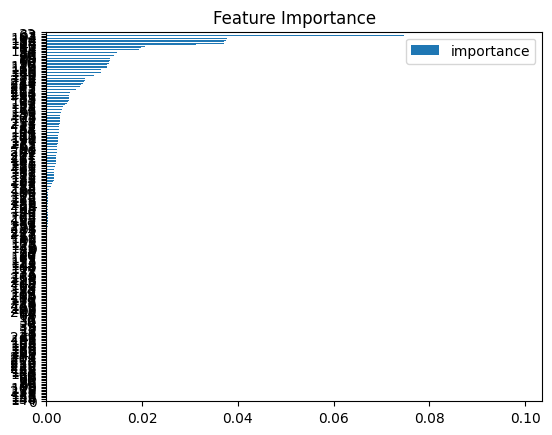

In [45]:
features_importance = pd.DataFrame(data=xgb_model_sklearn.feature_importances_,
            columns=['importance'])
features_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [56]:
import shap

In [66]:
import transformers

In [67]:
# load a transformers pipeline model
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

# explain the model on two sample inputs
explainer = shap.Explainer(model)
shap_values = explainer(["What a great movie! ...if you have no taste."])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.25s/it]               


In [68]:
explainer = shap.DeepExplainer(xgb_model_sklearn, X_train_xgb)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


ValueError: <class 'xgboost.sklearn.XGBRegressor'> is not currently a supported model type!

In [58]:
shap_values = explainer(X_test_xgb)

In [62]:
shap_values.shape

(6274, 240, 24)

In [60]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0,0])

TypeError: only size-1 arrays can be converted to Python scalars

#### Xgb.regressor w/ features importance

XGBoost provides a way to examine the importance of each feature in the original dataset within the model.

It involves counting the number of times each feature is split on across all boosting trees in the model.

Then we visualize the result as a bar graph, with the features ordered according to how many times they appear.

XGBoost has a plot_importance() function that helps us to achieve this task.

Then we can visualize the features that has been given the highest important score among all the features.

Thus XGBoost provides us a way to do feature selection.


In [46]:
train_size = 0.8
test_size = 0.2

# Esegui la suddivisione
df_train, df_test = train_test_split(dataset_input, train_size=train_size, test_size=test_size, shuffle=False)

# "shuffle=False" garantisce che i dati rimangano nell'ordine originale

In [47]:
features = ['PUN_d+1-7', 'PUN_d+1-14', 'GAS', 'GAS_d+1-7',"Total_load_f", "Total_Load_d+1-7", 'GiornoSettimana', 'Ora', 'holiday']
target = 'PUN'

X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

In [49]:
import xgboost as xgb
import seaborn as sns

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=5000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.1)



reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:162.84336	validation_1-rmse:148.41171
[100]	validation_0-rmse:14.69524	validation_1-rmse:27.74365
[200]	validation_0-rmse:12.42156	validation_1-rmse:27.66764
[270]	validation_0-rmse:11.45041	validation_1-rmse:27.66196


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

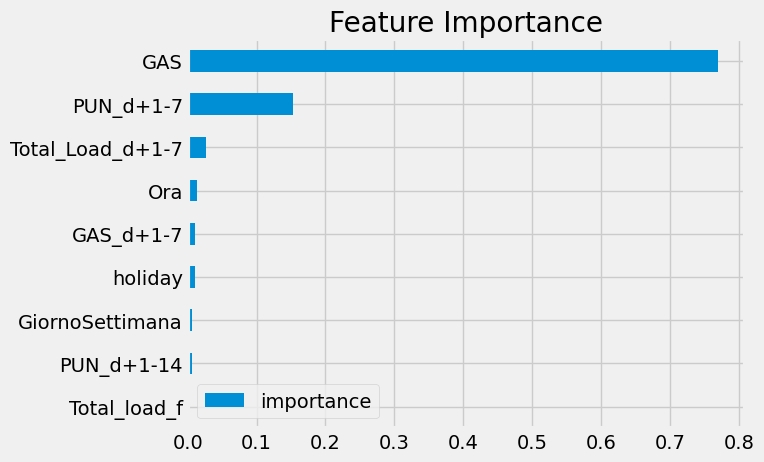

In [50]:
features_importance = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])
features_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
# df_2023.drop(columns='prediction', inplace=True)
# df_2021_22.drop(columns='prediction', inplace=True)


In [ ]:
df_test['prediction'] = reg.predict(X_test)
dataset_input = dataset_input.merge(df_test[['prediction']], how='left', left_index=True, right_index=True)

In [ ]:
y_test.shape

(3442,)

In [ ]:
single_timeseries_evaluation_metrics_func(df_test['prediction'].values, y_test)

Evaluation metric results:-
MAE is : 52.284
RMSE is : 71.555
MAPE is : 16.796
NMAE is : 0.157


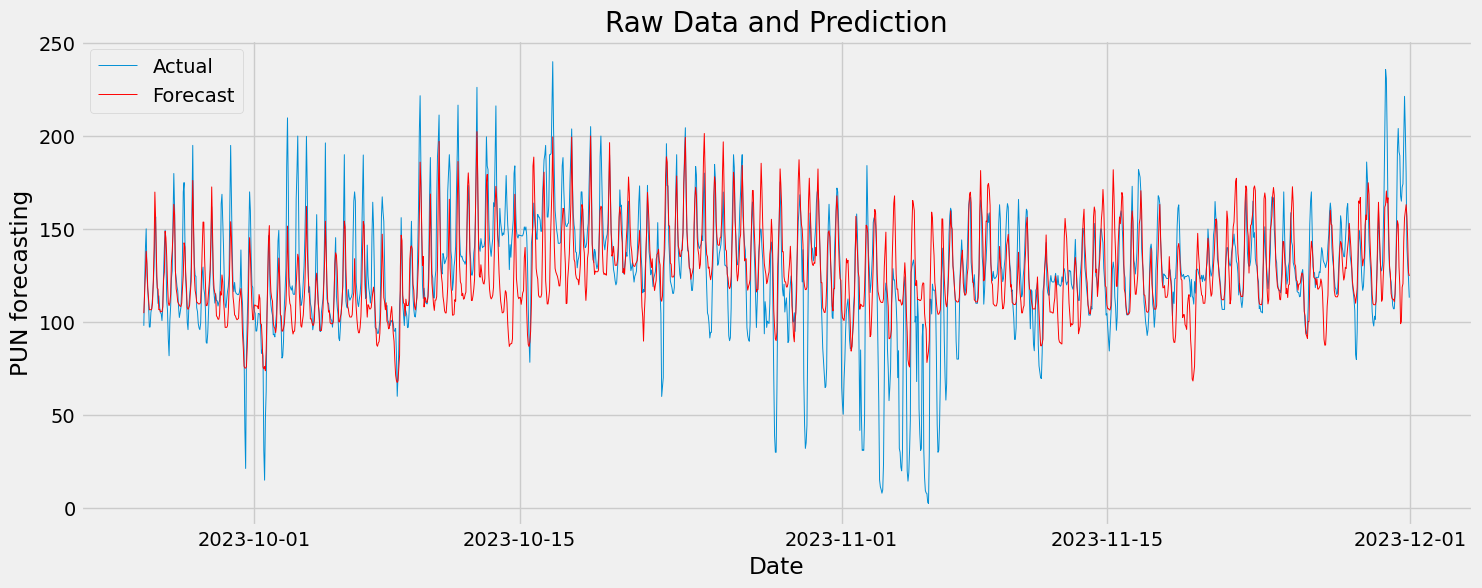

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(df_test['PUN'], linewidth=0.7, label='Actual')
plt.plot(df_test['prediction'], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()

